In [1]:
from __future__ import print_function

import logging
import sys
root_logger = logging.getLogger()
stdout_handler = logging.StreamHandler(sys.stdout)
root_logger.addHandler(stdout_handler)
root_logger.setLevel(logging.DEBUG)

import mxnet as mx
from mxnet import nd, autograd, sym, mod
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from src.fetch_mnist import preprocessed_mnist

In [2]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = preprocessed_mnist(random_state=0)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5) 
category_count = len(np.unique(y_train))

def data_iter(X, y, batch_size=250):
  batch_size = min(X.shape[0], batch_size)
  return mx.io.NDArrayIter(
    data=nd.array(X),
    label=nd.array(X),
    batch_size=batch_size,
    label_name='data')

train_iter = data_iter(X_train, y_train)
valid_iter = data_iter(X_valid, y_valid)
test_iter = data_iter(X_test, y_test)

/opt/anaconda3/envs/nnets/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


### We'll write autoencoders in MXNet.

Let's start with simple autoencoder - no regularization or fancy optimization techniques.

In [3]:
input_size = 784
hidden_size = 128 

training_param_args = {
  'num_epoch': 25,
  'eval_metric': 'rmse',
  'optimizer_params':{'learning_rate': 0.33}
}

In [4]:
def autoencoder_loss():
  data = sym.Variable('data')
  weights = sym.Variable(name='weighs', shape=(input_size, hidden_size), init=mx.init.Xavier())
  bias = sym.Variable(name='bias', shape=(hidden_size,), init=mx.init.Zero())
  bias_out = sym.Variable(name='bias_out', shape=(input_size,), init=mx.init.Zero())
  hid_in = sym.broadcast_add(
    sym.dot(data, weights, name='hidden_in'),
    bias
  )
  codes = sym.Activation(hid_in, act_type='relu', name='codes')
  hid_out = sym.dot(codes, weights.transpose(), name='hidden_out')
  out = sym.broadcast_add(
    sym.Activation(hid_out, act_type='relu', name='out'),
    bias_out
  )
  return mx.symbol.MakeLoss(
    mx.symbol.LinearRegressionOutput(data=out, label=data)
  )

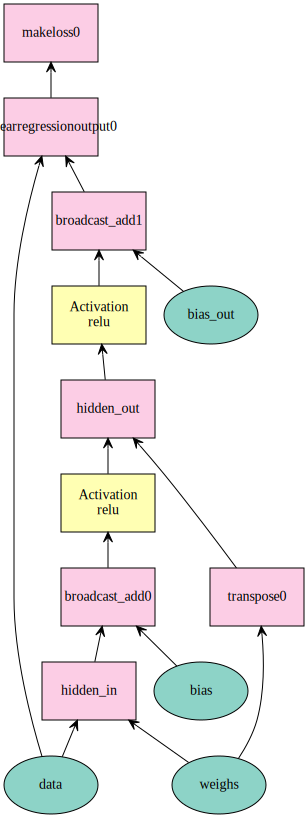

In [5]:
autoencoder = mod.Module(symbol=autoencoder_loss(), label_names=['data'])
mx.viz.plot_network(autoencoder.symbol)

In [6]:
%time autoencoder.fit(train_iter, eval_data=valid_iter, **training_param_args)

Epoch[0] Train-rmse=0.869617
Epoch[0] Time cost=3.585
Epoch[0] Validation-rmse=1.017736
Epoch[1] Train-rmse=0.793274
Epoch[1] Time cost=3.134
Epoch[1] Validation-rmse=0.951058
Epoch[2] Train-rmse=0.733324
Epoch[2] Time cost=2.897
Epoch[2] Validation-rmse=0.898994
Epoch[3] Train-rmse=0.687949
Epoch[3] Time cost=4.140
Epoch[3] Validation-rmse=0.856345
Epoch[4] Train-rmse=0.651626
Epoch[4] Time cost=3.399
Epoch[4] Validation-rmse=0.819288
Epoch[5] Train-rmse=0.621130
Epoch[5] Time cost=3.130
Epoch[5] Validation-rmse=0.786271
Epoch[6] Train-rmse=0.594812
Epoch[6] Time cost=4.051
Epoch[6] Validation-rmse=0.756572
Epoch[7] Train-rmse=0.571746
Epoch[7] Time cost=3.689
Epoch[7] Validation-rmse=0.729906
Epoch[8] Train-rmse=0.551363
Epoch[8] Time cost=3.719
Epoch[8] Validation-rmse=0.705949
Epoch[9] Train-rmse=0.533298
Epoch[9] Time cost=2.986
Epoch[9] Validation-rmse=0.684384
Epoch[10] Train-rmse=0.517202
Epoch[10] Time cost=3.050
Epoch[10] Validation-rmse=0.664951
Epoch[11] Train-rmse=0.502889

In [7]:
reconstructed_digits = autoencoder.predict(valid_iter)
autoencoder.score(test_iter, eval_metric='rmse')

[('rmse', 0.44013840066535131)]

In [8]:
def plot_two_img_rows(X1, X2, title, j=5):
  f, axes = plt.subplots(2, j, figsize=(20, 40 / j))
  f.suptitle(title)
  for k, x in zip(range(2), [X1, X2]):
    for i in range(j):
      ax = axes[k, i]
      img = x[i, :].reshape(28, 28)
      ax.imshow(img, cmap='gray')
      ax.axis('off')
  plt.show()

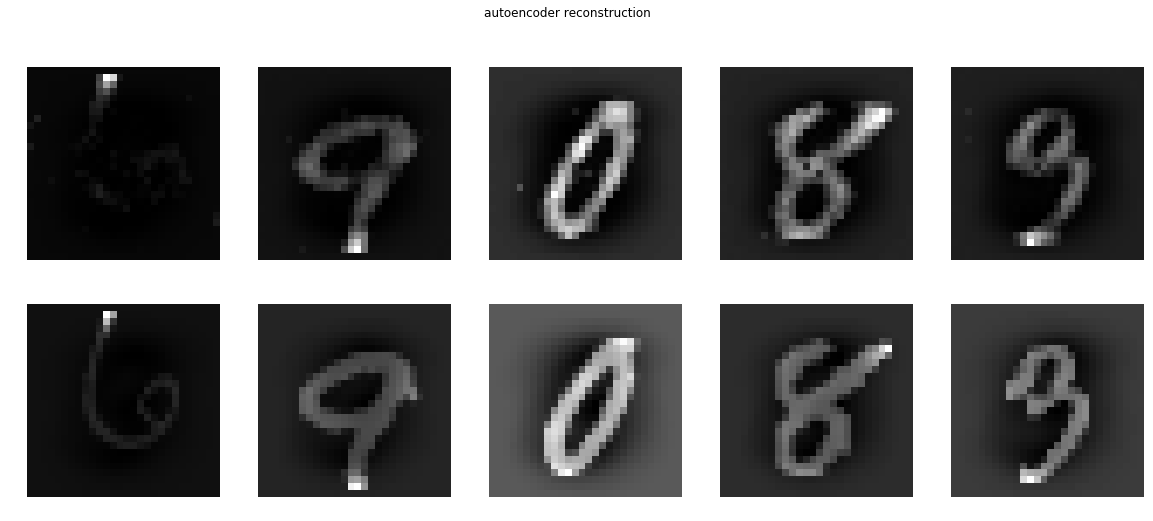

In [9]:
reconstructed_digit_examples = reconstructed_digits[:10, :].asnumpy()

plot_two_img_rows(reconstructed_digit_examples[:10], X_valid[:10], 'autoencoder reconstruction')

### Adding dropout 

In [10]:
def dropout_autoencoder_loss(p):
  data = sym.Variable('data')
  weights = sym.Dropout(
    p=p, 
    data=sym.Variable(
       name='weighs',
       shape=(input_size, hidden_size),
       init=mx.init.Xavier(),
       dtype='float32')
  )
  bias = sym.Variable(name='bias', shape=(hidden_size,), init=mx.init.Zero())
  hid_in = sym.broadcast_add(
    sym.dot(data, weights, name='hidden_in'),
    bias
  )
  codes = sym.Activation(hid_in, act_type='relu', name='codes')
  hid_out = sym.dot(codes, weights.transpose(), name='hidden_out') 
  out = sym.Activation(hid_out, act_type='relu', name='out')
  return mx.symbol.MakeLoss(
    mx.symbol.LinearRegressionOutput(data=out, label=data)
  )

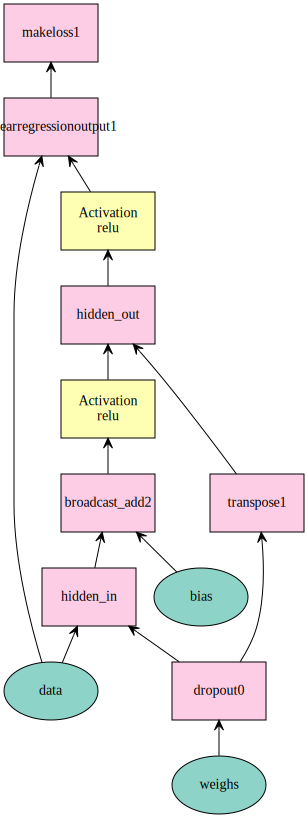

In [11]:
dropout_autoencoder = mod.Module(symbol=dropout_autoencoder_loss(p=0.33), label_names=['data'])
mx.viz.plot_network(dropout_autoencoder.symbol)

In [12]:
%time dropout_autoencoder.fit(train_iter, eval_data=valid_iter, **training_param_args)

Epoch[0] Train-rmse=0.889877
Epoch[0] Time cost=2.213
Epoch[0] Validation-rmse=1.046509
Epoch[1] Train-rmse=0.842255
Epoch[1] Time cost=2.543
Epoch[1] Validation-rmse=0.999704
Epoch[2] Train-rmse=0.802611
Epoch[2] Time cost=2.276
Epoch[2] Validation-rmse=0.956974
Epoch[3] Train-rmse=0.769363
Epoch[3] Time cost=2.150
Epoch[3] Validation-rmse=0.921143
Epoch[4] Train-rmse=0.743991
Epoch[4] Time cost=1.967
Epoch[4] Validation-rmse=0.891277
Epoch[5] Train-rmse=0.723154
Epoch[5] Time cost=1.968
Epoch[5] Validation-rmse=0.866259
Epoch[6] Train-rmse=0.705967
Epoch[6] Time cost=2.685
Epoch[6] Validation-rmse=0.847648
Epoch[7] Train-rmse=0.692142
Epoch[7] Time cost=1.942
Epoch[7] Validation-rmse=0.826171
Epoch[8] Train-rmse=0.681070
Epoch[8] Time cost=1.941
Epoch[8] Validation-rmse=0.807493
Epoch[9] Train-rmse=0.670166
Epoch[9] Time cost=1.901
Epoch[9] Validation-rmse=0.795528
Epoch[10] Train-rmse=0.660019
Epoch[10] Time cost=1.963
Epoch[10] Validation-rmse=0.780618
Epoch[11] Train-rmse=0.652437

In [13]:
dropout_reconstructed_digits = dropout_autoencoder.predict(valid_iter)
dropout_autoencoder.score(test_iter, eval_metric='rmse')

[('rmse', 0.62468066811561584)]

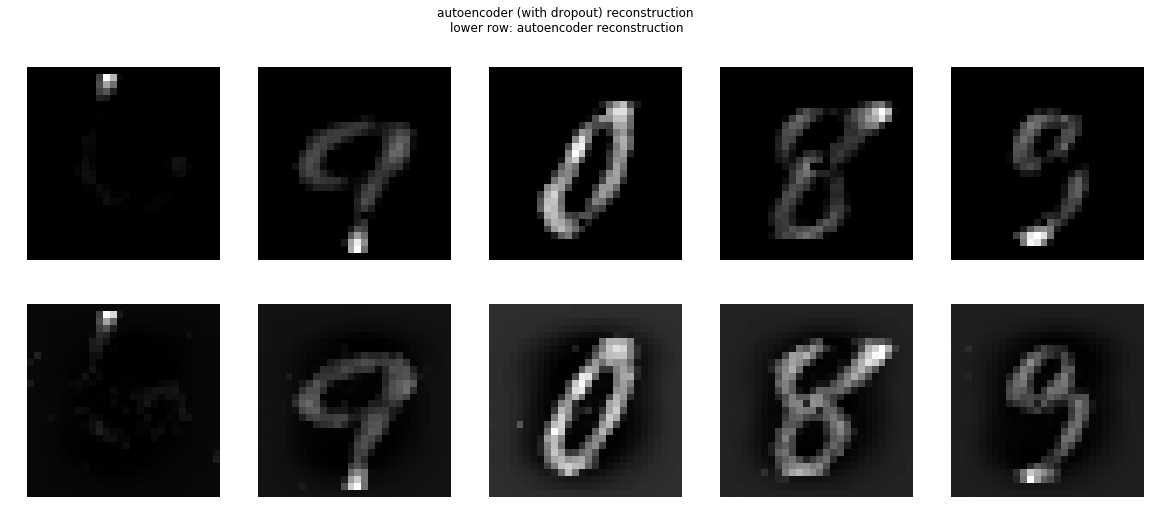

In [14]:
dropout_reconstructed_digit_examples = dropout_reconstructed_digits[:10, :].asnumpy()

plot_two_img_rows(dropout_reconstructed_digit_examples[:10], reconstructed_digit_examples[:10], 'autoencoder (with dropout) reconstruction \nlower row: autoencoder reconstruction')

### Denoising autoencoder (with continuous, normally distributed noise)

In [15]:
def denoising_autoencoder_loss(sigma, input_size, hidden_size):
  data = sym.Variable('data')
  noise = sym.Variable('noise', init=mx.init.Normal(sigma), shape=(input_size,), )
  noisy_data = sym.broadcast_plus(data, noise, name='noisy_data')
  bias = sym.Variable('bias', init=mx.init.Zero(), shape=(hidden_size,), )
  weights = sym.Variable(
       name='weighs',
       shape=(input_size, hidden_size),
       init=mx.init.Xavier(),
       dtype='float32')
  hid_in = sym.broadcast_add(
    sym.dot(noisy_data, weights, name='hidden_in'),
    bias,
    name='hid_in'
  )
  codes = sym.Activation(hid_in, act_type='relu', name='codes')
  hid_out = sym.dot(codes, weights.transpose(), name='hidden_out')
  out = sym.Activation(hid_out, act_type='relu', name='out')
  return mx.symbol.MakeLoss(
    mx.symbol.LinearRegressionOutput(data=out, label=data)
  )

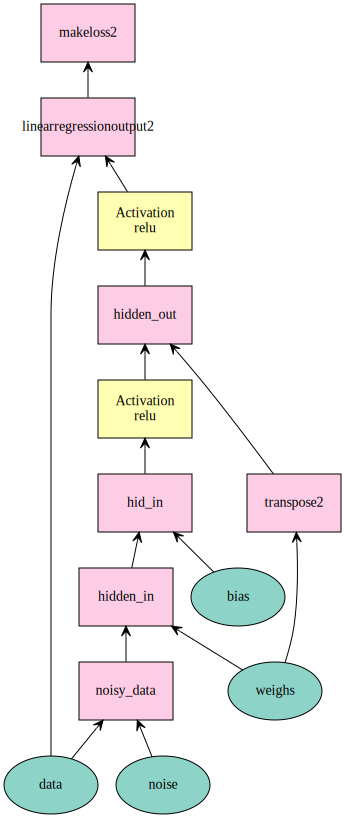

In [16]:
denoising_autoencoder = mod.Module(
  symbol=denoising_autoencoder_loss(sigma=0.01, input_size=input_size, hidden_size=hidden_size),
  label_names=['data'],
  fixed_param_names=['noise'])

mx.viz.plot_network(denoising_autoencoder.symbol)

In [17]:
%time denoising_autoencoder.fit(train_iter, eval_data=valid_iter, **training_param_args)

Epoch[0] Train-rmse=0.868082
Epoch[0] Time cost=2.319
Epoch[0] Validation-rmse=1.018507
Epoch[1] Train-rmse=0.795681
Epoch[1] Time cost=2.461
Epoch[1] Validation-rmse=0.957090
Epoch[2] Train-rmse=0.741301
Epoch[2] Time cost=1.768
Epoch[2] Validation-rmse=0.910772
Epoch[3] Train-rmse=0.701530
Epoch[3] Time cost=1.709
Epoch[3] Validation-rmse=0.873214
Epoch[4] Train-rmse=0.670666
Epoch[4] Time cost=1.694
Epoch[4] Validation-rmse=0.840713
Epoch[5] Train-rmse=0.645559
Epoch[5] Time cost=2.245
Epoch[5] Validation-rmse=0.811964
Epoch[6] Train-rmse=0.624719
Epoch[6] Time cost=2.242
Epoch[6] Validation-rmse=0.786495
Epoch[7] Train-rmse=0.607301
Epoch[7] Time cost=1.974
Epoch[7] Validation-rmse=0.764149
Epoch[8] Train-rmse=0.592658
Epoch[8] Time cost=1.850
Epoch[8] Validation-rmse=0.744693
Epoch[9] Train-rmse=0.580269
Epoch[9] Time cost=1.696
Epoch[9] Validation-rmse=0.727737
Epoch[10] Train-rmse=0.569698
Epoch[10] Time cost=1.986
Epoch[10] Validation-rmse=0.712888
Epoch[11] Train-rmse=0.560587

In [18]:
denoising_reconstructed_digits = denoising_autoencoder.predict(valid_iter)
denoising_autoencoder.score(test_iter, eval_metric='rmse')

[('rmse', 0.53675846010446548)]

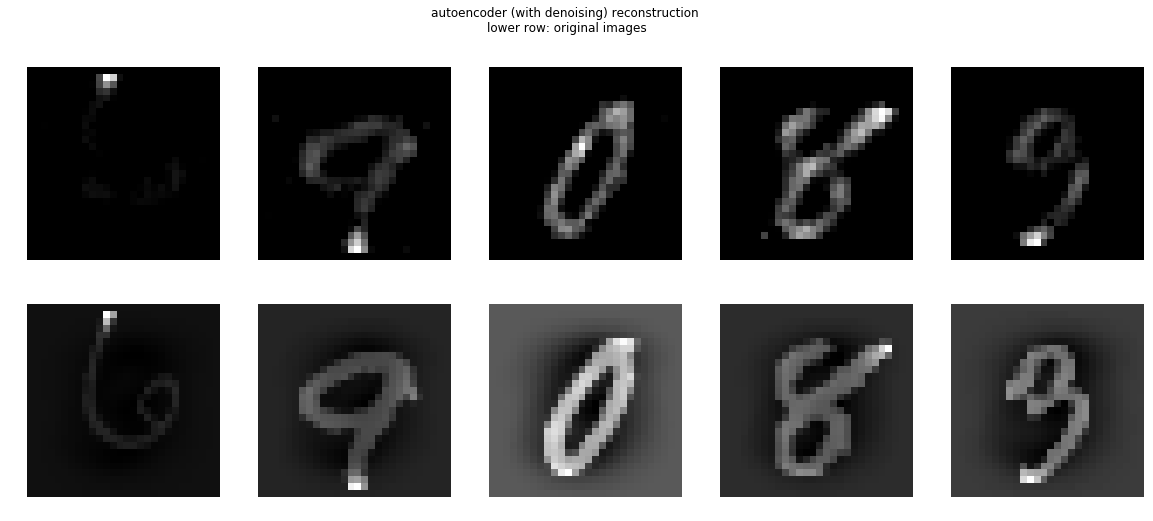

In [19]:
denoising_reconstructed_digit_examples = denoising_reconstructed_digits[:10, :].asnumpy()

plot_two_img_rows(denoising_reconstructed_digit_examples[:10], X_valid[:10], 'autoencoder (with denoising) reconstruction \nlower row: original images')